### Alunos
- Vitor de Oliveira Fernandez Araujo
- Vitor Sancho Cardoso

# Dados de Entrada
* Selecione "Adicionar ao Drive"
  *   https://tinyurl.com/bd-spotify







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt install openjdk-11-jdk -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libxcomposite1 libxt-dev libxtst6 libxxf86dga1
  openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  session-migration x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libxcomposite1 libxt-dev libxtst6 libxxf86dga1
  openjdk-11-jdk openjdk-11-jdk-headless openjdk-

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

from datetime import datetime

appName = 'Big Data Songs'
master = 'local[*]'

spark = SparkSession.builder     \
    .master(master) \
    .appName(appName) \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

# Leitura de dados e Processamento Básico

In [5]:
spotify_df = spark.read.parquet('/content/drive/MyDrive/spotify/spotify.parquet')

In [6]:
spotify_df.printSchema()

root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- daily_rank: integer (nullable = true)
 |-- daily_movement: integer (nullable = true)
 |-- weekly_movement: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- is_explicit: boolean (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: date (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable

In [7]:
continents_df = spark.read.parquet('/content/drive/MyDrive/spotify/continents.parquet')

In [8]:
# Observação: o campo alpha_2 contém o código do país
continents_df.printSchema()

root
 |-- country_name: string (nullable = true)
 |-- alpha_2: string (nullable = true)
 |-- alpha_3: string (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- iso_3166_2: string (nullable = true)
 |-- region: string (nullable = true)
 |-- sub_region: string (nullable = true)
 |-- intermediate_region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- sub_region_code: integer (nullable = true)
 |-- intermediate_region_code: integer (nullable = true)



In [9]:
continents_df = continents_df \
    .withColumnRenamed("alpha_2", "country")

## Join

In [10]:
spotify_df_with_locale = spotify_df.join(continents_df, on="country", how="left")

In [11]:
spotify_df_with_locale.printSchema()

root
 |-- country: string (nullable = true)
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- daily_rank: integer (nullable = true)
 |-- daily_movement: integer (nullable = true)
 |-- weekly_movement: integer (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- is_explicit: boolean (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: date (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable

In [12]:
spotify_df_with_locale.filter(spotify_df_with_locale['country'].isNull()).show(10)

+-------+--------------------+--------------------+--------------------+----------+--------------+---------------+-------------+----------+-----------+-----------+--------------------+------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------+-------+------------+----------+------+----------+-------------------+-----------+---------------+------------------------+
|country|          spotify_id|                name|             artists|daily_rank|daily_movement|weekly_movement|snapshot_date|popularity|is_explicit|duration_ms|          album_name|album_release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|country_name|alpha_3|country_code|iso_3166_2|region|sub_region|intermediate_region|region_code|sub_region_code|intermediate_region_code|
+-------+--------------------+--------------------+--------------------+--------

## Limpeza e enriquecimento do dataframe

In [13]:
spotify_df_with_locale.show(10)

+-------+--------------------+--------------------+--------------------+----------+--------------+---------------+-------------+----------+-----------+-----------+--------------------+------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------+-------+------------+----------+------+----------+-------------------+-----------+---------------+------------------------+
|country|          spotify_id|                name|             artists|daily_rank|daily_movement|weekly_movement|snapshot_date|popularity|is_explicit|duration_ms|          album_name|album_release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|country_name|alpha_3|country_code|iso_3166_2|region|sub_region|intermediate_region|region_code|sub_region_code|intermediate_region_code|
+-------+--------------------+--------------------+--------------------+--------

In [14]:
registros_invalidos = spotify_df_with_locale.filter(
    (col('name').isNull() | (col('name').isin(['', ' ','NA','N/A','NULL','null','-']))) |
    (col('artists').isNull() | (col('artists').isin(['', ' ','NA','N/A','NULL','null','-']))) |
    (col('album_name').isNull() | (col('album_name').isin(['', ' ','NA','N/A','NULL','null','-']))) |
    (col('album_release_date').isNull() | (col('album_release_date').isin(['', ' ','NA','N/A','NULL','null','-','1900-01-01']))) |
    (col('snapshot_date').isNull() | (col('snapshot_date').isin(['', ' ','NA','N/A','NULL','null','-',0]))) |
    (col('duration_ms').isNull() | (col('duration_ms').isin(['', ' ','NA','N/A','NULL','null','-',0]))))

print('Número de registros inválidos ou ausentes:', registros_invalidos.count())
print('Amostra de registros com nomes inválidos ou ausentes:')
registros_invalidos.show(5)
registros_invalidos_ids = registros_invalidos.select('spotify_id').rdd.flatMap(lambda x: x).distinct().collect()
registros_invalidos_ids

Número de registros inválidos ou ausentes: 2474
Amostra de registros com nomes inválidos ou ausentes:
+-------+--------------------+--------------------+--------------------+----------+--------------+---------------+-------------+----------+-----------+-----------+----------+------------------+------------+------+------+--------+----+-----------+------------+----------------+--------+-------+------+--------------+------------+-------+------------+----------+------+----------+-------------------+-----------+---------------+------------------------+
|country|          spotify_id|                name|             artists|daily_rank|daily_movement|weekly_movement|snapshot_date|popularity|is_explicit|duration_ms|album_name|album_release_date|danceability|energy|   key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|country_name|alpha_3|country_code|iso_3166_2|region|sub_region|intermediate_region|region_code|sub_region_code|intermediate_region_

['26zqmmkqUK6mCc87XDzPym',
 '6UulhuFnVh60zaE2q4tavZ',
 '5pOu3vSiKrEmj65N1CWqOI',
 '2GE2p2dFpxp7OIz2QOFBzW',
 '446ygEWkggc5FMbBPQSMuM',
 '3Nn9QjxOEj1pleW9xTG6cq',
 '0QRJSCMKuRyqVR886waeko',
 '10dCarem6DIkGBPEJoL6qv',
 '4HEOgBHRCExyYVeTyrXsnL',
 '5rRYtMoEDY3HrvV13jcsom',
 '0xxZY5C9xxij3D1HkzbnfC',
 '35wSewUpyeXwde8wVlHW7L',
 '07d8eaOuAWdC0DANq3tdPd',
 '0y2sUHVDAWQbfuIQGEfhFO',
 '7zxfM3Hi0cdeCsORWtXGKs',
 '5TtNxUZBjYR4wgzOpHpS7h',
 '1pwyiEOvhXLvlpzTZcgfhe',
 '73ax9vvEPz8yXm9TCrn2Y1',
 '0RKggS4he8LozKqMv09IrM',
 '2fDFssQASymjUb2B3XYdpf',
 '5ID0XfoI7DalBK8veu0MFC',
 '7pqx5vF7DzkVtEdsXQ9iua',
 '6lhwqbxrVsfCdTpfb7ga34',
 '3EQjXzlXY0dyOovq0Awe91',
 '193luTcDfusSUv3yqs1gGj',
 '6s9xQXSKc8tYMe1ZH5aiYs',
 '6A2ZwOsMeomTIVhLvfXngC',
 '2V2K1hzCtgj9xAnga9WUTy',
 '7lyv2sysHCzFjypILxAynT',
 '6yxtsR3nc3aUL1wcbLn8A3',
 '7gSQxwCpEMjg8wb6Y3oqe7',
 '2R1sqa3gaeCXkqwjNF6YLC',
 '5Dzz3fYAlIwK8vTUmJNAwN',
 '3yrSvpt2l1xhsV9Em88Pul',
 '2oVLEoBVDvYrGmzrU7dEm5',
 '0BX2eDMZJrGzApf4ZGXrFi',
 '3JIfmjJbanxJkwaPzYa2gN',
 

In [15]:
from pyspark.sql import functions as F
spotify_df.agg(F.min('snapshot_date'), F.max('snapshot_date')).show(10)

+------------------+------------------+
|min(snapshot_date)|max(snapshot_date)|
+------------------+------------------+
|        2023-10-18|        2025-06-11|
+------------------+------------------+



In [16]:
# remove de spotify_df_with_locale todos os itens analisados como inválidos: invalid_name_ids, invalid_duration_ms_ids, invalid_artist_ids
spotify_df_limpo = spotify_df_with_locale.filter(~col('spotify_id').isin(registros_invalidos_ids))


In [17]:
print('Número de registros removidos: ', spotify_df_with_locale.count() - spotify_df_limpo.count())

Número de registros removidos:  2580


# Questões de Análise

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

##Q1: A duração média das músicas ao longo do tempo está diminuindo?



In [19]:
colunas_desejadas = ["name", "duration_ms","album_release_date"]
dataset_q1 = spotify_df_limpo.select(colunas_desejadas)
dataset_q1 = dataset_q1.distinct()
dataset_q1 = dataset_q1.withColumn("ano", col("album_release_date").substr(0,4))
dataset_q1 = dataset_q1.groupBy("ano").agg(
    F.median("duration_ms").alias("mediana_valor"),
    F.avg("duration_ms").alias("media_valor"),
    F.count("duration_ms").alias("total_musicas")
)
dataset_q1.sort(asc('ano')).show(100)

+----+-------------+------------------+-------------+
| ano|mediana_valor|       media_valor|total_musicas|
+----+-------------+------------------+-------------+
|1939|     295760.0|          295760.0|            1|
|1942|     177480.0|          177480.0|            1|
|1945|     175333.0|171510.66666666666|            3|
|1947|     150266.0|          150266.0|            1|
|1951|     147466.0|          147466.0|            1|
|1952|     145773.0|          145773.0|            1|
|1953|     155466.0|          155466.0|            1|
|1955|     133426.0|          133426.0|            1|
|1957|     129173.0|          125324.0|            3|
|1958|     586866.0|          586866.0|            1|
|1959|     135760.0|          132213.0|            3|
|1960|     131733.0|          131733.0|            1|
|1961|     190973.0|          190973.0|            1|
|1962|     142520.0|          129706.5|            8|
|1963|     154466.5|          164938.5|            4|
|1964|     134766.5|        

In [20]:
primeiro_quartil = dataset_q1.approxQuantile("total_musicas", [0.25, 0.5, 0.75], 0.1)[0]
dataset_q1 = dataset_q1.filter(dataset_q1["total_musicas"] >= primeiro_quartil)
dataset_q1.sort(asc('ano')).show(100)

+----+-------------+------------------+-------------+
| ano|mediana_valor|       media_valor|total_musicas|
+----+-------------+------------------+-------------+
|1945|     175333.0|171510.66666666666|            3|
|1957|     129173.0|          125324.0|            3|
|1959|     135760.0|          132213.0|            3|
|1962|     142520.0|          129706.5|            8|
|1963|     154466.5|          164938.5|            4|
|1964|     134766.5|          140966.5|            4|
|1965|     153761.5|         153213.75|            4|
|1967|     188838.5|         194535.75|            8|
|1968|     163755.0|          179607.0|            3|
|1969|     192793.0|          182483.0|            4|
|1970|     160333.0| 171316.7142857143|            7|
|1971|     231173.0|243482.11111111112|            9|
|1972|     201881.0|         197530.25|            4|
|1973|     223460.0| 234631.2857142857|           14|
|1974|     250443.5|          238431.5|            4|
|1975|     224266.0|230268.1

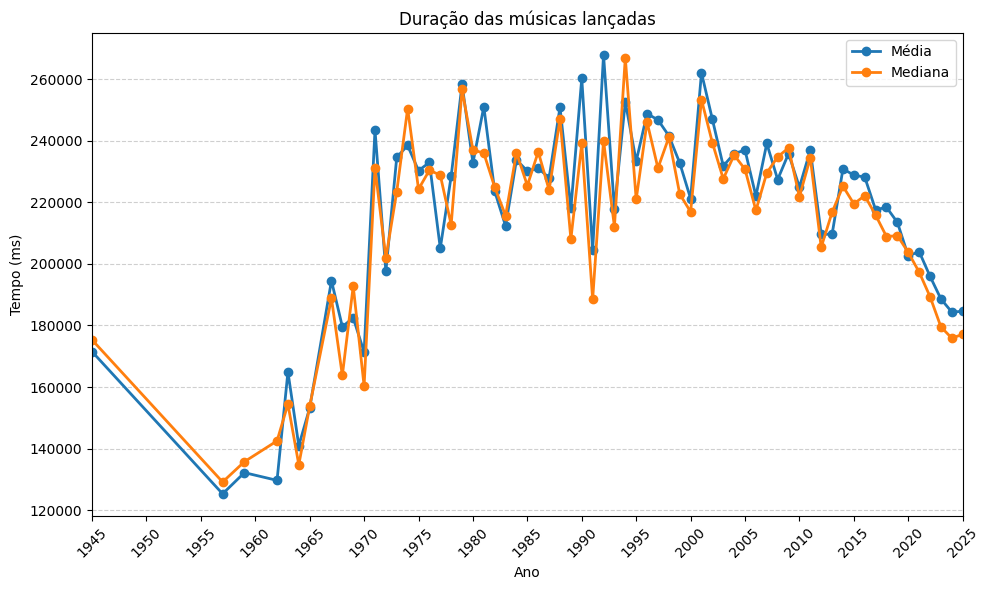

In [21]:
pdf = dataset_q1.toPandas()

# Garante que 'ano' é inteiro e ordena
pdf["ano"] = pdf["ano"].astype(int)
pdf = pdf.sort_values("ano")

# Define intervalo dos ticks: começa/termina em múltiplos de 5
min_year = pdf["ano"].min()
max_year = pdf["ano"].max()
start = (min_year // 5) * 5
end = ((max_year + 4) // 5) * 5

fig, ax = plt.subplots(figsize=(10, 6))

# Plota média e mediana
ax.plot(pdf["ano"], pdf["media_valor"], label="Média", linewidth=2, marker='o')
ax.plot(pdf["ano"], pdf["mediana_valor"], label="Mediana", linewidth=2, marker='o')

# Força ticks a cada 5 anos e remove ticks menores
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.NullLocator())

# Opcional: limitar a vista exatamente entre start e end
ax.set_xlim(start, end)

# Formatação dos rótulos do eixo x
ax.set_xticks(np.arange(start, end + 1, 5))
ax.set_xticklabels([str(y) for y in np.arange(start, end + 1, 5)], rotation=45)

ax.set_xlabel("Ano")
ax.set_ylabel("Tempo (ms)")
ax.set_title("Duração das músicas lançadas")
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()


**Metologia:**
Para a nossa análise, inicialmente criamos um dataset contendo os registros não duplicados para as colunas "name", "duration_ms","album_release_date". Em seguida criamos a coluna "ano" a partir da coluna que possui a data de lançamento do álbum ("album_release_date") que possui a respectiva música. Após isso fomos capazes de extrair o tempo médio e a mediada da duração das músicas lançadas em cada ano. Por fim, para remover anos com poucos registros de músicas lançadas e evitar o comprometimento da observação de tendências, foram removidos os anos que possuiam uma quantidade de lançamento de músicas inferior ao 4º quartil de quatidade de músicas por ano.

**Resultados:**
É possível notar que os anos de 1955 até 1970 foram produzidas músicas mais curtas dos que as vistas nos outros períodos da história. A partir de 1970 é podemos observar um aumento da média de duração das músicas. Isso pode ser explicado pelos avanços tecnológicos e da indústria de gravadoras no período, o que barateou o custo de produção e distribuição de músicas.
A duração média da música se manteve bem estável até por volta de 2010, ano que começamos a ver uma tendencia de queda. Um tese que pode ser usada para explicar isso são as recentes alterações no padrão de consumo e distribuição de mídias no geral, incluídos as músicas. Com a disseminação do uso de rede sociais, que estimulam cada vez o consumo de um grande volume de conteúdo de curta duração, isso pode estar afetando também a indústria da música.

##Q2: Quais artistas levam músicas ao top 10 global de forma mais rápida?

In [22]:
colunas_desejadas = ["artists", "name", "album_release_date","daily_rank","snapshot_date","country"]
dataset_q2 = spotify_df_limpo.select(colunas_desejadas)

dataset_q2_data_lancamento = dataset_q2.groupBy("name").agg(
    F.min("snapshot_date").alias("data_lancamento_proxy")
)

dataset_q2_chegada_no_top_10 = dataset_q2.filter((dataset_q2["daily_rank"] <= 10) & (dataset_q2["country"].isNull()))

dataset_q2_chegada_no_top_10 = dataset_q2_chegada_no_top_10.groupBy("name").agg(
    F.min("snapshot_date").alias("data_primeiro_aparecimento_top_10"),
    F.min("artists").alias("artists")
)

dataset_q2 = dataset_q2_chegada_no_top_10.join(dataset_q2_data_lancamento, on="name")

dataset_q2 = dataset_q2.withColumn("dias_ate_top_10", datediff(col("data_primeiro_aparecimento_top_10"), col("data_lancamento_proxy")))

dataset_q2 = dataset_q2.groupBy("artists").agg(
    F.avg("dias_ate_top_10").alias("qnt_media_de_dias_ate_top_10"),
    F.count("name").alias("total_de_musicas")
)

dataset_q2.sort(asc('qnt_media_de_dias_ate_top_10'),desc('total_de_musicas')).show(50)

+--------------------+----------------------------+----------------+
|             artists|qnt_media_de_dias_ate_top_10|total_de_musicas|
+--------------------+----------------------------+----------------+
|        Taylor Swift|                         0.0|              20|
|       Playboi Carti|                         0.0|               4|
|Future, Metro Boomin|                         0.0|               3|
|The Weeknd, Playb...|                         0.0|               2|
|            Dua Lipa|                         0.0|               2|
|Playboi Carti, Tr...|                         0.0|               2|
|             Beyoncé|                         0.0|               2|
|Taylor Swift, Pos...|                         0.0|               1|
|         Drake, Yeat|                         0.0|               1|
|Tate McRae, F1 Th...|                         0.0|               1|
|           Jung Kook|                         0.0|               1|
|Playboi Carti, Th...|            

Metodologia: Para a nossa análise, inicialmente criamos um dataset contendo os registros não duplicados para as colunas "artists", "name", "album_release_date","daily_rank","snapshot_date" e "country". Para usar como uma estimativa da data de lançamento da música, usamos o menor registro do campo snapshot_date, e o nomeamos como "data_lancamento_proxy". O próximo passo foi realizar um filtro de todos os registros que continham rank diário como menor ou igual a 10 e, para esses resgitros, extraímos a menor data de snapshot_date para considerá-la como a primeira aparição no top 10. Por fim, fizemos a substração entre a data de lançamento da música e a data de sua aparição no top 10. Para esse análise agrupamos os dados por artista, assim pudemos gerar um dataset que contém a média de dias que um artista leva para levar a música para o top e um total da quantidade de músicas que mais apareceram no top 10 global. Vale destacar também que aplicamos um filtro sobre o campo country, para que lidássemos sobre com os dados do ranking global.


Resultados: Para nossa surpresa, parece ser muito comum que no dia de lançamento da música ela já apareça no top 10. Não esperávamos esse comportamento. Os nossos resultados estão ordenados de acordo com a quantidade média de tempo até um artista levar suas músicas para o top 10. Podemos ver que a Taylor Swift levou 20 músicas para o top 10 já no dia do seu lançamento, o que chama atenção dado o volume de músicas. Outro destaque é Playboi Carti que levou 4 músicas para o top já no lançamento. Os primeiros lugares do dataset também possuem artistas que fazem sucesso global, como Drake, Beyoncé, Dua Lipa e até Anitta com uma música em parceria com The Weeknd.

##Q3: Quais são os países que mais consomem músicas com conteúdo explícito e como é essa evolução nos últimos 3 anos?

In [23]:
colunas_desejadas = ["snapshot_date", "is_explicit", "country_name"]
dataset_q3 = spotify_df_limpo.select(colunas_desejadas)

dataset_q3 = dataset_q3.filter(~dataset_q3["country_name"].isNull())
dataset_q3 = dataset_q3.withColumn("is_explicit_int", col('is_explicit').cast(IntegerType()))
dataset_q3 = dataset_q3.withColumn("ano", col("snapshot_date").substr(0,4))

dataset_q3_total_audicoes = dataset_q3.groupBy("country_name", "ano") \
  .agg(count("country_name").alias("total_audicoes"))

dataset_q3_total_audicoes_explicitas = dataset_q3.groupBy("country_name", "ano") \
  .agg(sum("is_explicit_int").alias("total_audicoes_explicitas"))

dataset_q3 = dataset_q3_total_audicoes.join(dataset_q3_total_audicoes_explicitas, on=['country_name', 'ano'])

dataset_q3 = dataset_q3.withColumn("%_audicoes_explicitas", col('total_audicoes_explicitas') / col('total_audicoes'))

In [24]:
dataset_q3.show()

+--------------------+----+--------------+-------------------------+---------------------+
|        country_name| ano|total_audicoes|total_audicoes_explicitas|%_audicoes_explicitas|
+--------------------+----+--------------+-------------------------+---------------------+
|               Spain|2024|         17555|                     7467|   0.4253489034463116|
|United Arab Emirates|2024|         17457|                     5848|   0.3349945580569399|
|            Slovakia|2024|         17665|                     9533|   0.5396546844041891|
|             Denmark|2024|         17503|                     7220|   0.4125007141632863|
|           Argentina|2024|         17703|                     4938|   0.2789357735976953|
|  Dominican Republic|2023|          3757|                     2787|   0.7418152781474581|
|              Panama|2025|          7700|                     3497|  0.45415584415584415|
|  Korea, Republic of|2025|          7700|                      680|  0.08831168831168831|

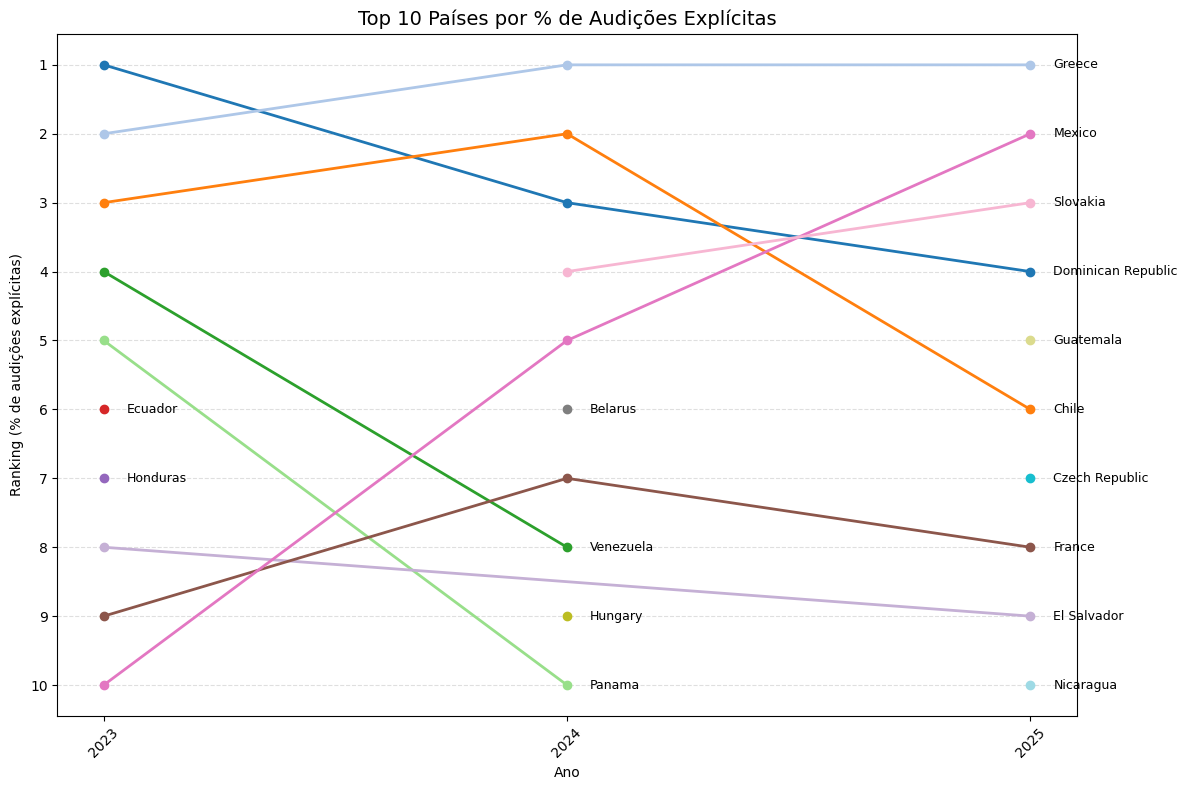

In [25]:
pdf = dataset_q3.toPandas()

pdf["ano"] = pdf["ano"].astype(int)
pdf["%_audicoes_explicitas"] = pdf["%_audicoes_explicitas"].astype(float)

pdf["rank"] = pdf.groupby("ano")["%_audicoes_explicitas"] \
                 .rank(method="first", ascending=False)

pdf_top10 = pdf[pdf["rank"] <= 10].copy()

pdf_top10 = pdf_top10.sort_values(["ano", "rank"])

plt.figure(figsize=(12, 8))

anos = sorted(pdf_top10["ano"].unique())
countries = pdf_top10["country_name"].unique()

colors = plt.cm.tab20(np.linspace(0, 1, len(countries)))
color_map = dict(zip(countries, colors))

for country in countries:
    df_country = pdf_top10[pdf_top10["country_name"] == country]

    plt.plot(
        df_country["ano"],
        df_country["rank"],
        marker="o",
        linewidth=2,
        label=country,
        color=color_map[country]
    )

    last_row = df_country[df_country["ano"] == df_country["ano"].max()]
    plt.text(
        last_row["ano"].values[0] + 0.05,
        last_row["rank"].values[0],
        country,
        va="center",
        fontsize=9
    )

plt.gca().invert_yaxis()

plt.xticks(anos, rotation=45)
plt.yticks(range(1, 11))  # só top 10

plt.title("Top 10 Países por % de Audições Explícitas", fontsize=14)
plt.xlabel("Ano")
plt.ylabel("Ranking (% de audições explícitas)")

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


/tmp/ipython-input-3367552669.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, "rank")) \


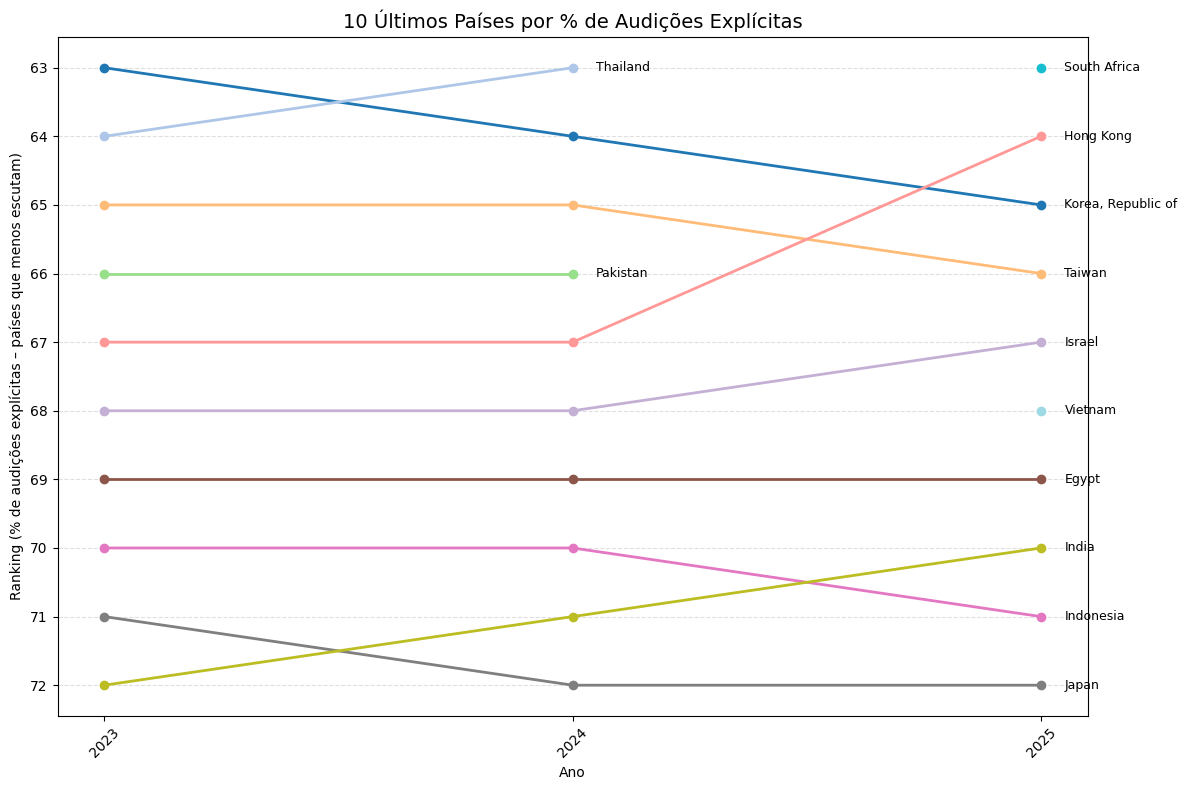

In [26]:
pdf = dataset_q3.toPandas()

pdf["ano"] = pdf["ano"].astype(int)
pdf["%_audicoes_explicitas"] = pdf["%_audicoes_explicitas"].astype(float)

pdf["rank"] = pdf.groupby("ano")["%_audicoes_explicitas"] \
                 .rank(method="first", ascending=False)

bottom10 = pdf.groupby("ano") \
              .apply(lambda x: x.nlargest(10, "rank")) \
              .reset_index(drop=True)

bottom10 = bottom10.sort_values(["ano", "rank"])

plt.figure(figsize=(12, 8))

anos = sorted(bottom10["ano"].unique())
countries = bottom10["country_name"].unique()

colors = plt.cm.tab20(np.linspace(0, 1, len(countries)))
color_map = dict(zip(countries, colors))

for country in countries:
    df_country = bottom10[bottom10["country_name"] == country]

    plt.plot(
        df_country["ano"],
        df_country["rank"],
        marker="o",
        linewidth=2,
        color=color_map[country]
    )

    last_row = df_country[df_country["ano"] == df_country["ano"].max()]
    plt.text(
        last_row["ano"].values[0] + 0.05,
        last_row["rank"].values[0],
        country,
        va="center",
        fontsize=9
    )

plt.gca().invert_yaxis()

plt.xticks(anos, rotation=45)
plt.yticks(range(int(bottom10["rank"].min()), int(bottom10["rank"].max()) + 1))

plt.title("10 Últimos Países por % de Audições Explícitas", fontsize=14)
plt.xlabel("Ano")
plt.ylabel("Ranking (% de audições explícitas – países que menos escutam)")

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


**Metodologia:** Para a nossa análise, inicialmente criamos um dataset contendo os registros para as colunas "snapshot_date", "is_explicit", "country_name". Em seguida removemos os dados do ranking global, extraímos o campo de data da coluna snapshot_date e criamos um inteiro do campo is_explicit para facilitar manipulações futuras. Depois disso, agrupamos os dados por países e criamos uma coluna contendo o total de musicas escutadas em cada um. Depois, tambem agrupando por países, somamos o total de músicas com conteúdo explícito, usando o inteiro associado ao campo is_explicit, criado anteriormente. Por fim, fizemos um cálculo do percentual de músicas escutadas que correspondem as que possuem conteúdo explícito. Para ajudar na análise, montamos dois gráfico, um com a evolução anual do top 10 países que mais escutam músicas com conteúdo explícito, e um segundo com os 10 que menos escutaram ao longo dos últimos 3 anos.

**Resultados:** Primeiramente falando sobre os países que mais escutam músicas com conteúdo explícito, o que mais nos chamou atenção é a grande presença de países latinos, como Ecuador, Honduras, Venezuela, Mexico, República Domonicana, Guatemala, Chile, Panamá, Guatemala e El Salvador. Os estilos de músicas mais consumidos nesses países estão muito associados à dança, como Reggaeton, Salsa e Pop Latino, e que provavelmente carregam em suas letras um teor mais sexual.
Já para os países que menos escutam, temos grande presença de países do Oriente do mundo, em excessão à Africa do Sul. Vemos então que isso está fortemente ligado a uma questão cultural desses países, principalmente de Japão, Indonésia, Vietnam e Coreia do Sul.

##Q4: Quais artistas tiveram uma popularidade curta (no máximo uma semana no top 100 mundial) ao longo dos últimos dois anos?

In [44]:
spotify_df_limpo.createOrReplaceTempView("spotify")

## obter lista dos artistas individuais e correlacionar com musicas
df_artist_song = (
    spotify_df_limpo.select("spotify_id", "artists")
    .withColumn("artist_raw", F.explode(F.split(F.col("artists"), ",")))
    .withColumn("artist", F.trim(F.col("artist_raw")))
    .filter(F.col("artist").isNotNull() & (F.col("artist") != ""))
    .drop("artist_raw")
)

df_artist_song.createOrReplaceTempView("artists_songs")

## apenas rank global
## rank acima de 100
## contar quantos dias cada musica ficou com rank global <= 100
songs_top100 = spark.sql("""
  select spotify_id, count(*) as days_top100
  from spotify
  where
    country is NULL and
    daily_rank <= 100 and
    daily_rank is not NULL
    and snapshot_date >= DATE '2023-11-16'
  group by spotify_id
""")

In [46]:
artist_song_days = (
    df_artist_song
    .join(songs_top100, on="spotify_id", how="inner")
)

# maximo de dias cada artista ocupou o top 100 e quantas músicas o fizeram
artist_stats = (
    artist_song_days
    .groupBy("artist")
    .agg(
        F.max("days_top100").alias("max_days_top100"),
        F.countDistinct("spotify_id").alias("num_tracks_top100"),
    )
)

# Artistas que:
# - têm pelo menos 1 música no top-100 (num_tracks_top100 > 0)
# - nenhuma música passou de 7 dias no top-100 (max_days_top100 <= 7)
artists_only_short = artist_stats.filter(
    (F.col("max_days_top100") <= 7) &
    (F.col("num_tracks_top100") > 0)
)

artists_only_short.orderBy(desc("max_days_top100")).show(100)


+--------------------+---------------+-----------------+
|              artist|max_days_top100|num_tracks_top100|
+--------------------+---------------+-----------------+
|       Manuel Turizo|              7|                1|
|             AzChike|              7|                2|
|              Miguel|              7|                1|
|            Az Chike|              7|                1|
|         Chuck Berry|              7|                1|
|            Jay Rock|              6|                2|
|             Mahmood|              6|                2|
|             DJ TOPO|              6|                1|
|       Blake Shelton|              6|                2|
|              Laufey|              6|                1|
|           Mc Leozin|              6|                1|
|                a-ha|              6|                1|
|              MC G15|              6|                2|
|          Elton John|              6|                4|
|           Seu Jorge|         

Nesta análise, tínhamos o objetivo de identificar artistas com popularidade passageira, que ocuparam o top-100 global por menos de sete dias, ao longo do periodo de dois anos. Para isso, compilamos a quantidade de dias que cada música ocupou o top-100 e realizamos um processamento dos artistas compositores, para segregar casos de composições em parceria. Com isto, chegamos na lista acima, com alguns nomes clássicos, como: Chuck Berry, A-ha, Elton John... Isso indica que estes artistas ainda são ouvidos pelo público global, mas não são lembrados com muita frequência.

##Q5: Baseado no BPM das músicas top 10 de cada dia, qual o tempo médio das músicas favoritas de cada país em 2025?

In [28]:
tempo_by_country_2025 = spark.sql("""
    WITH top10_2025 AS (
        SELECT
            country_name,
            snapshot_date,
            tempo
        FROM
            spotify
        WHERE
            snapshot_date >= DATE '2025-01-01'
            AND snapshot_date < DATE '2026-01-01'
            AND daily_rank <= 10
            AND country is not NULL -- não queremos usar o rank global
    ),
    daily_country_avg AS (
        SELECT
            country_name,
            snapshot_date,
            AVG(tempo) AS avg_bpm_day
        FROM
            top10_2025
        GROUP BY
            country_name,
            snapshot_date
    )
    SELECT
        country_name,
        AVG(avg_bpm_day) AS avg_bpm
    FROM
        daily_country_avg
    GROUP BY
        country_name
""")

tempo_by_country_2025.orderBy(F.desc("avg_bpm")).show(100)

+--------------------+------------------+
|        country_name|           avg_bpm|
+--------------------+------------------+
|            Bulgaria|142.43427597402595|
|         Philippines|135.58240714285722|
|             Austria| 135.5233857142857|
|              Brazil| 135.3826422077922|
|             Germany|  135.353948051948|
|United Arab Emirates|134.37803896103895|
|            Malaysia|133.51867857142855|
|               Japan|132.88293996458077|
|             Romania|132.37485324675322|
|             Estonia|131.59276717827623|
|      Czech Republic|131.37495844155842|
|             Iceland|130.20739285714282|
|         Switzerland|129.93412272727267|
|         Netherlands|129.32493896103892|
|              Taiwan|129.07303376623383|
|           Singapore| 128.7550253246754|
|          Luxembourg|128.70524610389617|
|           Argentina| 128.3048103896104|
|        Saudi Arabia|128.13992857142853|
|           Lithuania|128.10702662337667|
|             Morocco| 127.4084982

In [29]:
top_brazil = spark.sql("""
    WITH songs AS (
      SELECT DISTINCT spotify_id, artists, name
      FROM spotify
    )
    SELECT artists, name FROM (
      SELECT
          spotify_id,
          sum(daily_rank) as sum_rank
      FROM
          spotify
      WHERE
          country = 'BR' AND
          snapshot_date >= DATE '2025-01-01' AND
          snapshot_date < DATE '2026-01-01'
          and daily_rank <= 10
      GROUP BY spotify_id
    ) top_sum
    JOIN songs
    ON top_sum.spotify_id = songs.spotify_id
    ORDER BY sum_rank ASC
""")

top_brazil.show(10)

+--------------------+--------------------+
|             artists|                name|
+--------------------+--------------------+
| Diego & Victor Hugo|  Tubarões - Ao Vivo|
|Bella Angel, Melo...|              Bigode|
| Zé Neto & Cristiano|Escondendo o Ouro...|
|DJ Douglinhas, DJ...|PUTA É SÓ UM DETALHE|
|           Lady Gaga|          Poker Face|
| MC LUUKY, DJ JB Mix|          Malvadinho|
|DJ Douglinhas, DJ...|Puta É Só um Detalhe|
|    Felipe e Rodrigo| Banquinho - Ao Vivo|
|           Lady Gaga|               Judas|
|DJ KN DE VILA VEL...|     Sentar pro Trem|
+--------------------+--------------------+
only showing top 10 rows



Vemos que a média dos 5 primeiros países está acima dos 135 BPM, indicando uma predileção por músicas mais agitadas. Inclusive, o Brasil ocupa a quarta posição, provavelmente por conta de gêneros como o funk, o rap e o pop. Como não temos informação direta do gênero musical no dataset, trouxemos uma amostra das músicas que ocuparam lugares elevados no rank brasileiro por mais tempo, em 2025. De fato, vemos muita presença de funk, pop, mas também sertanejo.

##Q6: ...